# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for MNIST dataset. Conditional image generation is the task of generating new images conditional on their class. Feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

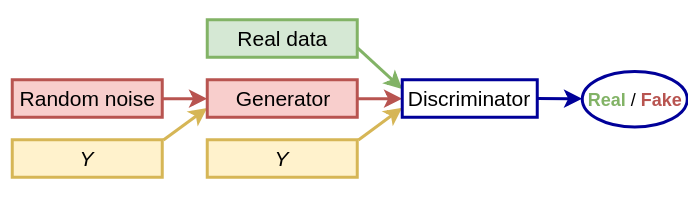

Picture source: https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011

### Imports

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from tqdm import tqdm

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [3]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
number_class = 10

if device == "cuda":
    !nvidia-smi

sample_dir = "./images"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Load dataset and create dataloader

In [4]:
# Load MNIST dataset
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 15 Patch objects>)

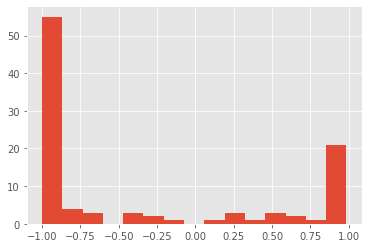

In [5]:
# plot pixels distribution
img, label = mnist[0]
print('Label: ', label)
# Your code here
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [6]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    # Your code here
    image = (x + 1.) / 2
    return image

Label:  5
Label: 5


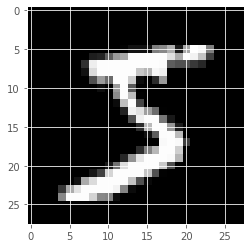

In [7]:
# Let's plot something
img, label = mnist[0]
print("Label: ", label)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [8]:
number_class = 10
embedding_dim = 10

class Generator(nn.Module):
    def __init__(
        self,
        latent_size,
        image_size,
        hidden_size,
        number_class,
        embedding_dim
    ): # pass number_class and use nn.Embedding here
        # linear1 - relu - linear2 - relu - linear3 - tanh
        super(Generator, self).__init__()
        
        self.class_embedding = nn.Embedding(
            num_embeddings=number_class,
            embedding_dim=embedding_dim
        )
        self.linear_1 = nn.Linear(latent_size + embedding_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, image_size)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, label):
        
        label_emb = self.class_embedding(label).squeeze()
        x = torch.cat([x, label_emb], dim=1)
        
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.tanh(self.linear_3(x))
        
        return x


class Discriminator(nn.Module):
    def __init__(
        self,
        image_size,
        hidden_size,
        number_class,
        embedding_dim
        ): # pass number_class and use nn.Embedding here
        # linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        self.class_embedding = nn.Embedding(
            num_embeddings=number_class,
            embedding_dim=embedding_dim
        )
        
        self.linear_1 = nn.Linear(image_size + embedding_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, label):
        # concat label embedding with input image
        
        label_emb = self.class_embedding(label).squeeze()
        
        x = torch.cat([x, label_emb], dim=1)

        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.sigmoid(self.linear_3(x))

        return x

Answer the question: why the last layer of generator is $Tanh$ and the last discriminator layer is $Sigmoid$?

In [9]:
# create new Generator model

G = Generator(
    latent_size=latent_size,
    image_size=image_size,
    hidden_size=hidden_size,
    number_class=number_class,
    embedding_dim=embedding_dim,
)

# create new Discriminator model

D = Discriminator(
    image_size=image_size,
    hidden_size=hidden_size,
    number_class=number_class,
    embedding_dim=embedding_dim
)

In [10]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator
d_optimizer = torch.optim.AdamW(D.parameters(), lr=LR)
g_optimizer = torch.optim.AdamW(G.parameters(), lr=LR)

### Discriminator Training

In [11]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(
    D_model,
    G_model,
    images,
    label):
    # Loss for real images
    real_labels = torch.ones(batch_size, 1).to(device)
    outputs = D_model(images, label)
    real_score = outputs.squeeze().unsqueeze(1)
    
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    fake_images = G_model(z, label)
    outputs = D_model(fake_images, label)
    fake_score = outputs.squeeze().unsqueeze(1)
    d_loss_fake = criterion(fake_score, fake_labels)
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()
    
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

### Generator Training

In [12]:
def train_generator(G_model, D_model):
    # Sample random vector
    z = torch.randn(batch_size, latent_size).to(device)
    gens_label = torch.randint(0, 10, (batch_size, 1)).to(device)
    labels = torch.ones(batch_size, 1).to(device)

    # Generate fake images and calculate loss
    fake_images = G_model(z, gens_label)
    outputs = D_model(fake_images, gens_label)
    fake_score = outputs.squeeze().unsqueeze(1)
    g_loss = criterion(fake_score, labels)
    

    # Backprop and optimize
    reset_grad()
    
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [13]:
def save_fake_images(G_model, index):
    # Sample random vector
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    gens_label = torch.tensor([[i] * 10 for i in range(10)]).view(-1, 1).to(device)
    # Generate images with Generator
    fake_images = G_model(sample_vectors, gens_label)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [14]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in tqdm(range(num_epochs)):
    for i, (images, digit) in enumerate(dataloader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        digit = digit.reshape(-1, 1).to(device)

        # Train the discriminator and generator

        d_loss, real_score, fake_score = train_discriminator(D, G, images, digit)
        
        g_loss, fake_images = train_generator(G, D)
        

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images(G, epoch + 1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/600], d_loss: 0.0756, g_loss: 3.6007, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.1499, g_loss: 4.7886, D(x): 0.97, D(G(z)): 0.10


  0%|          | 1/300 [00:25<2:05:41, 25.22s/it]

Epoch [0/300], Step [600/600], d_loss: 0.0359, g_loss: 4.6153, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.2004, g_loss: 4.2770, D(x): 0.93, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 1.8130, g_loss: 1.9560, D(x): 0.47, D(G(z)): 0.16


  1%|          | 2/300 [00:49<2:01:49, 24.53s/it]

Epoch [1/300], Step [600/600], d_loss: 0.3511, g_loss: 3.1037, D(x): 0.87, D(G(z)): 0.13
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1716, g_loss: 3.4779, D(x): 0.97, D(G(z)): 0.13
Epoch [2/300], Step [400/600], d_loss: 0.5860, g_loss: 2.4391, D(x): 0.87, D(G(z)): 0.31


  1%|          | 3/300 [01:15<2:04:46, 25.21s/it]

Epoch [2/300], Step [600/600], d_loss: 0.9723, g_loss: 2.1239, D(x): 0.73, D(G(z)): 0.32
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.8617, g_loss: 1.5987, D(x): 0.78, D(G(z)): 0.36
Epoch [3/300], Step [400/600], d_loss: 0.2049, g_loss: 3.9444, D(x): 0.94, D(G(z)): 0.09


  1%|▏         | 4/300 [01:40<2:04:07, 25.16s/it]

Epoch [3/300], Step [600/600], d_loss: 0.6503, g_loss: 2.2857, D(x): 0.83, D(G(z)): 0.29
Saving fake_images-0004.png
Epoch [4/300], Step [200/600], d_loss: 0.9221, g_loss: 2.9936, D(x): 0.75, D(G(z)): 0.27
Epoch [4/300], Step [400/600], d_loss: 0.4541, g_loss: 2.1513, D(x): 0.83, D(G(z)): 0.19


  2%|▏         | 5/300 [02:05<2:04:27, 25.31s/it]

Epoch [4/300], Step [600/600], d_loss: 1.8527, g_loss: 0.8282, D(x): 0.44, D(G(z)): 0.40
Saving fake_images-0005.png
Epoch [5/300], Step [200/600], d_loss: 1.0995, g_loss: 1.5309, D(x): 0.69, D(G(z)): 0.43
Epoch [5/300], Step [400/600], d_loss: 3.3994, g_loss: 1.0341, D(x): 0.36, D(G(z)): 0.65


  2%|▏         | 6/300 [02:30<2:03:01, 25.11s/it]

Epoch [5/300], Step [600/600], d_loss: 1.3622, g_loss: 1.0802, D(x): 0.54, D(G(z)): 0.26
Saving fake_images-0006.png
Epoch [6/300], Step [200/600], d_loss: 0.4825, g_loss: 2.4274, D(x): 0.81, D(G(z)): 0.14
Epoch [6/300], Step [400/600], d_loss: 0.7204, g_loss: 2.0601, D(x): 0.73, D(G(z)): 0.21


  2%|▏         | 7/300 [02:55<2:02:05, 25.00s/it]

Epoch [6/300], Step [600/600], d_loss: 1.6808, g_loss: 1.0881, D(x): 0.62, D(G(z)): 0.55
Saving fake_images-0007.png
Epoch [7/300], Step [200/600], d_loss: 0.6221, g_loss: 1.9930, D(x): 0.76, D(G(z)): 0.23
Epoch [7/300], Step [400/600], d_loss: 1.7479, g_loss: 1.1644, D(x): 0.52, D(G(z)): 0.50


  3%|▎         | 8/300 [03:24<2:07:42, 26.24s/it]

Epoch [7/300], Step [600/600], d_loss: 1.4177, g_loss: 0.9494, D(x): 0.55, D(G(z)): 0.48
Saving fake_images-0008.png
Epoch [8/300], Step [200/600], d_loss: 1.3917, g_loss: 1.3986, D(x): 0.45, D(G(z)): 0.23
Epoch [8/300], Step [400/600], d_loss: 1.7622, g_loss: 1.0581, D(x): 0.55, D(G(z)): 0.56


  3%|▎         | 9/300 [03:49<2:04:59, 25.77s/it]

Epoch [8/300], Step [600/600], d_loss: 0.5414, g_loss: 1.7767, D(x): 0.80, D(G(z)): 0.23
Saving fake_images-0009.png
Epoch [9/300], Step [200/600], d_loss: 1.0161, g_loss: 1.3761, D(x): 0.62, D(G(z)): 0.28
Epoch [9/300], Step [400/600], d_loss: 0.4100, g_loss: 2.4962, D(x): 0.86, D(G(z)): 0.16


  3%|▎         | 10/300 [04:13<2:02:27, 25.34s/it]

Epoch [9/300], Step [600/600], d_loss: 0.7586, g_loss: 1.8517, D(x): 0.74, D(G(z)): 0.25
Saving fake_images-0010.png
Epoch [10/300], Step [200/600], d_loss: 0.4844, g_loss: 2.7964, D(x): 0.84, D(G(z)): 0.19
Epoch [10/300], Step [400/600], d_loss: 1.6166, g_loss: 1.9101, D(x): 0.56, D(G(z)): 0.30


  4%|▎         | 11/300 [04:37<2:00:35, 25.04s/it]

Epoch [10/300], Step [600/600], d_loss: 0.8005, g_loss: 1.8482, D(x): 0.71, D(G(z)): 0.23
Saving fake_images-0011.png
Epoch [11/300], Step [200/600], d_loss: 0.4177, g_loss: 2.4040, D(x): 0.80, D(G(z)): 0.14
Epoch [11/300], Step [400/600], d_loss: 1.4470, g_loss: 1.0262, D(x): 0.56, D(G(z)): 0.41


  4%|▍         | 12/300 [05:04<2:03:08, 25.65s/it]

Epoch [11/300], Step [600/600], d_loss: 2.1975, g_loss: 0.9922, D(x): 0.40, D(G(z)): 0.51
Saving fake_images-0012.png
Epoch [12/300], Step [200/600], d_loss: 1.5433, g_loss: 0.7939, D(x): 0.55, D(G(z)): 0.53
Epoch [12/300], Step [400/600], d_loss: 1.5795, g_loss: 0.7331, D(x): 0.50, D(G(z)): 0.50


  4%|▍         | 13/300 [05:29<2:01:17, 25.36s/it]

Epoch [12/300], Step [600/600], d_loss: 1.8610, g_loss: 0.9451, D(x): 0.39, D(G(z)): 0.43
Saving fake_images-0013.png
Epoch [13/300], Step [200/600], d_loss: 0.8115, g_loss: 1.3663, D(x): 0.74, D(G(z)): 0.34
Epoch [13/300], Step [400/600], d_loss: 1.3048, g_loss: 0.8663, D(x): 0.63, D(G(z)): 0.47


  5%|▍         | 14/300 [05:54<1:59:57, 25.17s/it]

Epoch [13/300], Step [600/600], d_loss: 1.6862, g_loss: 1.0041, D(x): 0.41, D(G(z)): 0.44
Saving fake_images-0014.png
Epoch [14/300], Step [200/600], d_loss: 1.0845, g_loss: 1.0289, D(x): 0.57, D(G(z)): 0.36
Epoch [14/300], Step [400/600], d_loss: 1.3331, g_loss: 0.7238, D(x): 0.54, D(G(z)): 0.45


  5%|▌         | 15/300 [06:18<1:58:49, 25.01s/it]

Epoch [14/300], Step [600/600], d_loss: 1.0946, g_loss: 1.1296, D(x): 0.64, D(G(z)): 0.37
Saving fake_images-0015.png
Epoch [15/300], Step [200/600], d_loss: 0.5824, g_loss: 1.7036, D(x): 0.80, D(G(z)): 0.26
Epoch [15/300], Step [400/600], d_loss: 0.4510, g_loss: 1.7395, D(x): 0.84, D(G(z)): 0.21


  5%|▌         | 16/300 [06:43<1:57:50, 24.90s/it]

Epoch [15/300], Step [600/600], d_loss: 0.6908, g_loss: 1.6838, D(x): 0.81, D(G(z)): 0.33
Saving fake_images-0016.png
Epoch [16/300], Step [200/600], d_loss: 0.8176, g_loss: 1.8151, D(x): 0.78, D(G(z)): 0.36
Epoch [16/300], Step [400/600], d_loss: 0.6050, g_loss: 1.7852, D(x): 0.78, D(G(z)): 0.24


  6%|▌         | 17/300 [07:07<1:56:47, 24.76s/it]

Epoch [16/300], Step [600/600], d_loss: 0.6542, g_loss: 1.9958, D(x): 0.79, D(G(z)): 0.27
Saving fake_images-0017.png
Epoch [17/300], Step [200/600], d_loss: 0.6389, g_loss: 1.5916, D(x): 0.78, D(G(z)): 0.27
Epoch [17/300], Step [400/600], d_loss: 0.4685, g_loss: 2.2518, D(x): 0.79, D(G(z)): 0.15


  6%|▌         | 18/300 [07:32<1:56:27, 24.78s/it]

Epoch [17/300], Step [600/600], d_loss: 0.9186, g_loss: 1.4746, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0018.png
Epoch [18/300], Step [200/600], d_loss: 0.5632, g_loss: 3.0352, D(x): 0.79, D(G(z)): 0.11
Epoch [18/300], Step [400/600], d_loss: 0.2831, g_loss: 2.5147, D(x): 0.92, D(G(z)): 0.15


  6%|▋         | 19/300 [07:57<1:56:09, 24.80s/it]

Epoch [18/300], Step [600/600], d_loss: 0.5395, g_loss: 2.6919, D(x): 0.83, D(G(z)): 0.22
Saving fake_images-0019.png
Epoch [19/300], Step [200/600], d_loss: 0.3162, g_loss: 2.3024, D(x): 0.88, D(G(z)): 0.13
Epoch [19/300], Step [400/600], d_loss: 0.4773, g_loss: 3.3731, D(x): 0.79, D(G(z)): 0.08


  7%|▋         | 20/300 [08:22<1:55:57, 24.85s/it]

Epoch [19/300], Step [600/600], d_loss: 0.6819, g_loss: 3.1092, D(x): 0.73, D(G(z)): 0.12
Saving fake_images-0020.png
Epoch [20/300], Step [200/600], d_loss: 0.5164, g_loss: 2.9077, D(x): 0.82, D(G(z)): 0.18
Epoch [20/300], Step [400/600], d_loss: 0.8075, g_loss: 2.3826, D(x): 0.80, D(G(z)): 0.32


  7%|▋         | 21/300 [08:49<1:57:53, 25.35s/it]

Epoch [20/300], Step [600/600], d_loss: 0.5292, g_loss: 2.7399, D(x): 0.80, D(G(z)): 0.14
Saving fake_images-0021.png
Epoch [21/300], Step [200/600], d_loss: 0.5856, g_loss: 2.0278, D(x): 0.80, D(G(z)): 0.20
Epoch [21/300], Step [400/600], d_loss: 1.1130, g_loss: 1.1226, D(x): 0.71, D(G(z)): 0.45


  7%|▋         | 22/300 [09:13<1:56:44, 25.20s/it]

Epoch [21/300], Step [600/600], d_loss: 0.8789, g_loss: 1.5298, D(x): 0.69, D(G(z)): 0.28
Saving fake_images-0022.png
Epoch [22/300], Step [200/600], d_loss: 0.6617, g_loss: 2.4009, D(x): 0.78, D(G(z)): 0.20
Epoch [22/300], Step [400/600], d_loss: 0.4028, g_loss: 2.3380, D(x): 0.91, D(G(z)): 0.22


  8%|▊         | 23/300 [09:39<1:56:51, 25.31s/it]

Epoch [22/300], Step [600/600], d_loss: 0.6992, g_loss: 1.9894, D(x): 0.81, D(G(z)): 0.28
Saving fake_images-0023.png
Epoch [23/300], Step [200/600], d_loss: 0.8081, g_loss: 1.9953, D(x): 0.80, D(G(z)): 0.33
Epoch [23/300], Step [400/600], d_loss: 0.2990, g_loss: 2.7503, D(x): 0.88, D(G(z)): 0.11


  8%|▊         | 24/300 [10:05<1:56:55, 25.42s/it]

Epoch [23/300], Step [600/600], d_loss: 0.7103, g_loss: 1.7425, D(x): 0.83, D(G(z)): 0.31
Saving fake_images-0024.png
Epoch [24/300], Step [200/600], d_loss: 0.9430, g_loss: 2.6839, D(x): 0.69, D(G(z)): 0.17
Epoch [24/300], Step [400/600], d_loss: 0.3790, g_loss: 3.0659, D(x): 0.90, D(G(z)): 0.18


  8%|▊         | 25/300 [10:31<1:57:13, 25.58s/it]

Epoch [24/300], Step [600/600], d_loss: 0.6134, g_loss: 2.5718, D(x): 0.77, D(G(z)): 0.17
Saving fake_images-0025.png
Epoch [25/300], Step [200/600], d_loss: 0.6578, g_loss: 2.3330, D(x): 0.79, D(G(z)): 0.21
Epoch [25/300], Step [400/600], d_loss: 0.4291, g_loss: 2.2639, D(x): 0.83, D(G(z)): 0.16


  9%|▊         | 26/300 [10:56<1:56:26, 25.50s/it]

Epoch [25/300], Step [600/600], d_loss: 0.5641, g_loss: 3.0131, D(x): 0.85, D(G(z)): 0.23
Saving fake_images-0026.png
Epoch [26/300], Step [200/600], d_loss: 0.7687, g_loss: 1.6471, D(x): 0.81, D(G(z)): 0.30
Epoch [26/300], Step [400/600], d_loss: 0.8964, g_loss: 2.2575, D(x): 0.78, D(G(z)): 0.24


  9%|▉         | 27/300 [11:21<1:55:01, 25.28s/it]

Epoch [26/300], Step [600/600], d_loss: 0.9428, g_loss: 1.7148, D(x): 0.66, D(G(z)): 0.20
Saving fake_images-0027.png
Epoch [27/300], Step [200/600], d_loss: 0.4448, g_loss: 2.9133, D(x): 0.87, D(G(z)): 0.18
Epoch [27/300], Step [400/600], d_loss: 0.5323, g_loss: 2.7483, D(x): 0.77, D(G(z)): 0.11


  9%|▉         | 28/300 [11:46<1:54:06, 25.17s/it]

Epoch [27/300], Step [600/600], d_loss: 0.5705, g_loss: 2.2884, D(x): 0.79, D(G(z)): 0.17
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.4924, g_loss: 2.3973, D(x): 0.86, D(G(z)): 0.18
Epoch [28/300], Step [400/600], d_loss: 0.7405, g_loss: 2.0090, D(x): 0.79, D(G(z)): 0.27


 10%|▉         | 29/300 [12:12<1:54:43, 25.40s/it]

Epoch [28/300], Step [600/600], d_loss: 0.8725, g_loss: 2.3294, D(x): 0.76, D(G(z)): 0.29
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4697, g_loss: 2.5734, D(x): 0.84, D(G(z)): 0.12
Epoch [29/300], Step [400/600], d_loss: 1.0045, g_loss: 2.5580, D(x): 0.72, D(G(z)): 0.21


 10%|█         | 30/300 [12:36<1:53:32, 25.23s/it]

Epoch [29/300], Step [600/600], d_loss: 0.6877, g_loss: 1.9824, D(x): 0.77, D(G(z)): 0.25
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.5556, g_loss: 2.9594, D(x): 0.79, D(G(z)): 0.17
Epoch [30/300], Step [400/600], d_loss: 0.6245, g_loss: 2.1240, D(x): 0.84, D(G(z)): 0.26


 10%|█         | 31/300 [13:02<1:53:13, 25.26s/it]

Epoch [30/300], Step [600/600], d_loss: 0.8692, g_loss: 2.7279, D(x): 0.85, D(G(z)): 0.36
Saving fake_images-0031.png
Epoch [31/300], Step [200/600], d_loss: 0.4988, g_loss: 1.9609, D(x): 0.82, D(G(z)): 0.18
Epoch [31/300], Step [400/600], d_loss: 0.5883, g_loss: 2.3962, D(x): 0.84, D(G(z)): 0.24


 11%|█         | 32/300 [13:26<1:51:49, 25.03s/it]

Epoch [31/300], Step [600/600], d_loss: 0.9469, g_loss: 2.4157, D(x): 0.70, D(G(z)): 0.11
Saving fake_images-0032.png
Epoch [32/300], Step [200/600], d_loss: 0.5901, g_loss: 2.8435, D(x): 0.80, D(G(z)): 0.16
Epoch [32/300], Step [400/600], d_loss: 0.6807, g_loss: 2.4113, D(x): 0.83, D(G(z)): 0.20


 11%|█         | 33/300 [13:51<1:51:17, 25.01s/it]

Epoch [32/300], Step [600/600], d_loss: 0.4328, g_loss: 3.0006, D(x): 0.84, D(G(z)): 0.13
Saving fake_images-0033.png
Epoch [33/300], Step [200/600], d_loss: 0.4696, g_loss: 2.9181, D(x): 0.85, D(G(z)): 0.18
Epoch [33/300], Step [400/600], d_loss: 0.6192, g_loss: 2.8738, D(x): 0.78, D(G(z)): 0.17


 11%|█▏        | 34/300 [14:17<1:51:20, 25.12s/it]

Epoch [33/300], Step [600/600], d_loss: 0.7822, g_loss: 1.8669, D(x): 0.77, D(G(z)): 0.27
Saving fake_images-0034.png
Epoch [34/300], Step [200/600], d_loss: 0.5849, g_loss: 2.3198, D(x): 0.88, D(G(z)): 0.27
Epoch [34/300], Step [400/600], d_loss: 0.6039, g_loss: 2.5272, D(x): 0.76, D(G(z)): 0.14


 12%|█▏        | 35/300 [14:42<1:51:14, 25.19s/it]

Epoch [34/300], Step [600/600], d_loss: 0.5496, g_loss: 2.6907, D(x): 0.83, D(G(z)): 0.20
Saving fake_images-0035.png
Epoch [35/300], Step [200/600], d_loss: 0.6003, g_loss: 2.6770, D(x): 0.77, D(G(z)): 0.11
Epoch [35/300], Step [400/600], d_loss: 0.5011, g_loss: 2.9064, D(x): 0.84, D(G(z)): 0.16


 12%|█▏        | 36/300 [15:07<1:51:08, 25.26s/it]

Epoch [35/300], Step [600/600], d_loss: 0.4145, g_loss: 2.6224, D(x): 0.86, D(G(z)): 0.15
Saving fake_images-0036.png
Epoch [36/300], Step [200/600], d_loss: 0.5607, g_loss: 1.7365, D(x): 0.79, D(G(z)): 0.19
Epoch [36/300], Step [400/600], d_loss: 0.7308, g_loss: 2.1474, D(x): 0.75, D(G(z)): 0.19


 12%|█▏        | 37/300 [15:33<1:51:16, 25.39s/it]

Epoch [36/300], Step [600/600], d_loss: 0.4464, g_loss: 2.8293, D(x): 0.81, D(G(z)): 0.13
Saving fake_images-0037.png
Epoch [37/300], Step [200/600], d_loss: 0.6805, g_loss: 2.4844, D(x): 0.75, D(G(z)): 0.17
Epoch [37/300], Step [400/600], d_loss: 0.8673, g_loss: 2.2992, D(x): 0.70, D(G(z)): 0.19


 13%|█▎        | 38/300 [16:02<1:55:42, 26.50s/it]

Epoch [37/300], Step [600/600], d_loss: 0.7707, g_loss: 2.3068, D(x): 0.83, D(G(z)): 0.31
Saving fake_images-0038.png
Epoch [38/300], Step [200/600], d_loss: 0.4682, g_loss: 2.5387, D(x): 0.85, D(G(z)): 0.19
Epoch [38/300], Step [400/600], d_loss: 0.6166, g_loss: 2.1221, D(x): 0.80, D(G(z)): 0.19


 13%|█▎        | 39/300 [16:28<1:54:37, 26.35s/it]

Epoch [38/300], Step [600/600], d_loss: 0.5733, g_loss: 2.9269, D(x): 0.80, D(G(z)): 0.14
Saving fake_images-0039.png
Epoch [39/300], Step [200/600], d_loss: 0.7752, g_loss: 2.2700, D(x): 0.73, D(G(z)): 0.19
Epoch [39/300], Step [400/600], d_loss: 0.8298, g_loss: 2.2900, D(x): 0.72, D(G(z)): 0.22


 13%|█▎        | 40/300 [16:54<1:53:27, 26.18s/it]

Epoch [39/300], Step [600/600], d_loss: 0.6838, g_loss: 2.6630, D(x): 0.75, D(G(z)): 0.13
Saving fake_images-0040.png
Epoch [40/300], Step [200/600], d_loss: 0.5768, g_loss: 2.7069, D(x): 0.84, D(G(z)): 0.24
Epoch [40/300], Step [400/600], d_loss: 0.7810, g_loss: 1.7835, D(x): 0.78, D(G(z)): 0.26


 14%|█▎        | 41/300 [17:20<1:52:20, 26.03s/it]

Epoch [40/300], Step [600/600], d_loss: 0.7376, g_loss: 2.4860, D(x): 0.76, D(G(z)): 0.22
Saving fake_images-0041.png
Epoch [41/300], Step [200/600], d_loss: 0.8080, g_loss: 2.2374, D(x): 0.80, D(G(z)): 0.30
Epoch [41/300], Step [400/600], d_loss: 0.6118, g_loss: 2.4370, D(x): 0.84, D(G(z)): 0.25


 14%|█▍        | 42/300 [17:45<1:51:37, 25.96s/it]

Epoch [41/300], Step [600/600], d_loss: 0.6453, g_loss: 2.5364, D(x): 0.77, D(G(z)): 0.20
Saving fake_images-0042.png
Epoch [42/300], Step [200/600], d_loss: 0.5445, g_loss: 2.3785, D(x): 0.86, D(G(z)): 0.24
Epoch [42/300], Step [400/600], d_loss: 0.7522, g_loss: 1.8250, D(x): 0.75, D(G(z)): 0.21


 14%|█▍        | 43/300 [18:11<1:50:31, 25.80s/it]

Epoch [42/300], Step [600/600], d_loss: 0.8356, g_loss: 1.9554, D(x): 0.70, D(G(z)): 0.18
Saving fake_images-0043.png
Epoch [43/300], Step [200/600], d_loss: 0.6006, g_loss: 2.5219, D(x): 0.78, D(G(z)): 0.15
Epoch [43/300], Step [400/600], d_loss: 0.4893, g_loss: 2.1985, D(x): 0.87, D(G(z)): 0.23


 15%|█▍        | 44/300 [18:36<1:49:18, 25.62s/it]

Epoch [43/300], Step [600/600], d_loss: 0.6103, g_loss: 1.5180, D(x): 0.79, D(G(z)): 0.21
Saving fake_images-0044.png
Epoch [44/300], Step [200/600], d_loss: 0.6325, g_loss: 2.0190, D(x): 0.80, D(G(z)): 0.25
Epoch [44/300], Step [400/600], d_loss: 0.4910, g_loss: 2.7454, D(x): 0.83, D(G(z)): 0.16


 15%|█▌        | 45/300 [19:03<1:50:22, 25.97s/it]

Epoch [44/300], Step [600/600], d_loss: 0.7395, g_loss: 2.6016, D(x): 0.68, D(G(z)): 0.10
Saving fake_images-0045.png
Epoch [45/300], Step [200/600], d_loss: 0.7930, g_loss: 2.5002, D(x): 0.82, D(G(z)): 0.31
Epoch [45/300], Step [400/600], d_loss: 0.6426, g_loss: 1.9511, D(x): 0.81, D(G(z)): 0.25


 15%|█▌        | 46/300 [19:29<1:49:33, 25.88s/it]

Epoch [45/300], Step [600/600], d_loss: 0.4883, g_loss: 2.9435, D(x): 0.84, D(G(z)): 0.17
Saving fake_images-0046.png
Epoch [46/300], Step [200/600], d_loss: 0.8048, g_loss: 1.7318, D(x): 0.74, D(G(z)): 0.24
Epoch [46/300], Step [400/600], d_loss: 0.7339, g_loss: 1.7626, D(x): 0.76, D(G(z)): 0.26


 16%|█▌        | 47/300 [19:54<1:48:56, 25.84s/it]

Epoch [46/300], Step [600/600], d_loss: 0.9083, g_loss: 2.1636, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0047.png
Epoch [47/300], Step [200/600], d_loss: 0.5856, g_loss: 2.7014, D(x): 0.79, D(G(z)): 0.16
Epoch [47/300], Step [400/600], d_loss: 0.5440, g_loss: 2.1225, D(x): 0.87, D(G(z)): 0.22


 16%|█▌        | 48/300 [20:20<1:47:50, 25.68s/it]

Epoch [47/300], Step [600/600], d_loss: 0.6258, g_loss: 2.3464, D(x): 0.77, D(G(z)): 0.18
Saving fake_images-0048.png
Epoch [48/300], Step [200/600], d_loss: 0.5359, g_loss: 2.6567, D(x): 0.86, D(G(z)): 0.21
Epoch [48/300], Step [400/600], d_loss: 0.5460, g_loss: 2.6582, D(x): 0.84, D(G(z)): 0.20


 16%|█▋        | 49/300 [20:45<1:46:56, 25.56s/it]

Epoch [48/300], Step [600/600], d_loss: 0.6260, g_loss: 2.4205, D(x): 0.77, D(G(z)): 0.20
Saving fake_images-0049.png
Epoch [49/300], Step [200/600], d_loss: 0.6026, g_loss: 2.0381, D(x): 0.84, D(G(z)): 0.24
Epoch [49/300], Step [400/600], d_loss: 0.8297, g_loss: 2.0495, D(x): 0.73, D(G(z)): 0.24


 17%|█▋        | 50/300 [21:10<1:45:34, 25.34s/it]

Epoch [49/300], Step [600/600], d_loss: 0.5582, g_loss: 2.7206, D(x): 0.80, D(G(z)): 0.17
Saving fake_images-0050.png
Epoch [50/300], Step [200/600], d_loss: 0.6726, g_loss: 2.1646, D(x): 0.76, D(G(z)): 0.17
Epoch [50/300], Step [400/600], d_loss: 0.9028, g_loss: 2.2647, D(x): 0.71, D(G(z)): 0.26


 17%|█▋        | 51/300 [21:35<1:44:40, 25.22s/it]

Epoch [50/300], Step [600/600], d_loss: 0.8222, g_loss: 2.0979, D(x): 0.76, D(G(z)): 0.27
Saving fake_images-0051.png
Epoch [51/300], Step [200/600], d_loss: 0.6626, g_loss: 2.2815, D(x): 0.82, D(G(z)): 0.27
Epoch [51/300], Step [400/600], d_loss: 0.7682, g_loss: 2.4301, D(x): 0.75, D(G(z)): 0.20


 17%|█▋        | 52/300 [22:00<1:44:07, 25.19s/it]

Epoch [51/300], Step [600/600], d_loss: 0.5962, g_loss: 2.1776, D(x): 0.83, D(G(z)): 0.24
Saving fake_images-0052.png
Epoch [52/300], Step [200/600], d_loss: 0.7495, g_loss: 2.3582, D(x): 0.76, D(G(z)): 0.23
Epoch [52/300], Step [400/600], d_loss: 0.6636, g_loss: 1.9531, D(x): 0.74, D(G(z)): 0.15


 18%|█▊        | 53/300 [22:25<1:43:21, 25.11s/it]

Epoch [52/300], Step [600/600], d_loss: 0.6677, g_loss: 2.7413, D(x): 0.75, D(G(z)): 0.16
Saving fake_images-0053.png
Epoch [53/300], Step [200/600], d_loss: 0.7733, g_loss: 2.5674, D(x): 0.73, D(G(z)): 0.20
Epoch [53/300], Step [400/600], d_loss: 0.8849, g_loss: 2.1094, D(x): 0.74, D(G(z)): 0.28


 18%|█▊        | 54/300 [22:51<1:44:11, 25.41s/it]

Epoch [53/300], Step [600/600], d_loss: 0.6672, g_loss: 1.8131, D(x): 0.79, D(G(z)): 0.25
Saving fake_images-0054.png
Epoch [54/300], Step [200/600], d_loss: 0.8029, g_loss: 2.6050, D(x): 0.68, D(G(z)): 0.15
Epoch [54/300], Step [400/600], d_loss: 0.6724, g_loss: 2.1681, D(x): 0.83, D(G(z)): 0.29


 18%|█▊        | 55/300 [23:16<1:42:56, 25.21s/it]

Epoch [54/300], Step [600/600], d_loss: 0.7604, g_loss: 2.6195, D(x): 0.73, D(G(z)): 0.23
Saving fake_images-0055.png
Epoch [55/300], Step [200/600], d_loss: 0.6933, g_loss: 2.0430, D(x): 0.74, D(G(z)): 0.20
Epoch [55/300], Step [400/600], d_loss: 0.8502, g_loss: 1.8847, D(x): 0.75, D(G(z)): 0.28


 19%|█▊        | 56/300 [23:40<1:42:07, 25.11s/it]

Epoch [55/300], Step [600/600], d_loss: 0.8533, g_loss: 1.8757, D(x): 0.76, D(G(z)): 0.29
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.7992, g_loss: 2.0802, D(x): 0.70, D(G(z)): 0.24
Epoch [56/300], Step [400/600], d_loss: 0.6269, g_loss: 2.1404, D(x): 0.82, D(G(z)): 0.22


 19%|█▉        | 57/300 [24:05<1:41:26, 25.05s/it]

Epoch [56/300], Step [600/600], d_loss: 0.9963, g_loss: 2.1407, D(x): 0.75, D(G(z)): 0.32
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6748, g_loss: 2.0382, D(x): 0.79, D(G(z)): 0.26
Epoch [57/300], Step [400/600], d_loss: 0.7004, g_loss: 1.9000, D(x): 0.80, D(G(z)): 0.27


 19%|█▉        | 58/300 [24:30<1:40:35, 24.94s/it]

Epoch [57/300], Step [600/600], d_loss: 0.6842, g_loss: 1.7119, D(x): 0.77, D(G(z)): 0.24
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6086, g_loss: 2.2824, D(x): 0.79, D(G(z)): 0.20
Epoch [58/300], Step [400/600], d_loss: 1.1885, g_loss: 1.6303, D(x): 0.62, D(G(z)): 0.31


 20%|█▉        | 59/300 [24:55<1:39:55, 24.88s/it]

Epoch [58/300], Step [600/600], d_loss: 0.7590, g_loss: 1.9780, D(x): 0.72, D(G(z)): 0.25
Saving fake_images-0059.png
Epoch [59/300], Step [200/600], d_loss: 0.7629, g_loss: 1.7074, D(x): 0.78, D(G(z)): 0.27
Epoch [59/300], Step [400/600], d_loss: 0.7073, g_loss: 1.8744, D(x): 0.82, D(G(z)): 0.31


 20%|██        | 60/300 [25:19<1:39:09, 24.79s/it]

Epoch [59/300], Step [600/600], d_loss: 1.0256, g_loss: 1.3230, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0060.png
Epoch [60/300], Step [200/600], d_loss: 0.8799, g_loss: 1.4878, D(x): 0.70, D(G(z)): 0.28
Epoch [60/300], Step [400/600], d_loss: 0.7370, g_loss: 2.2000, D(x): 0.77, D(G(z)): 0.26


 20%|██        | 61/300 [25:44<1:38:37, 24.76s/it]

Epoch [60/300], Step [600/600], d_loss: 0.8276, g_loss: 1.8707, D(x): 0.72, D(G(z)): 0.26
Saving fake_images-0061.png
Epoch [61/300], Step [200/600], d_loss: 0.8852, g_loss: 1.5132, D(x): 0.73, D(G(z)): 0.31
Epoch [61/300], Step [400/600], d_loss: 1.0764, g_loss: 1.5162, D(x): 0.67, D(G(z)): 0.32


 21%|██        | 62/300 [26:10<1:39:46, 25.15s/it]

Epoch [61/300], Step [600/600], d_loss: 1.0703, g_loss: 1.6920, D(x): 0.75, D(G(z)): 0.39
Saving fake_images-0062.png
Epoch [62/300], Step [200/600], d_loss: 0.9489, g_loss: 1.4990, D(x): 0.75, D(G(z)): 0.35
Epoch [62/300], Step [400/600], d_loss: 0.8087, g_loss: 1.7786, D(x): 0.73, D(G(z)): 0.28


 21%|██        | 63/300 [26:35<1:38:47, 25.01s/it]

Epoch [62/300], Step [600/600], d_loss: 1.0459, g_loss: 1.5750, D(x): 0.61, D(G(z)): 0.29
Saving fake_images-0063.png
Epoch [63/300], Step [200/600], d_loss: 0.8611, g_loss: 1.9222, D(x): 0.71, D(G(z)): 0.29
Epoch [63/300], Step [400/600], d_loss: 0.9050, g_loss: 1.4491, D(x): 0.76, D(G(z)): 0.35


 21%|██▏       | 64/300 [26:59<1:37:51, 24.88s/it]

Epoch [63/300], Step [600/600], d_loss: 1.0049, g_loss: 1.9259, D(x): 0.67, D(G(z)): 0.27
Saving fake_images-0064.png
Epoch [64/300], Step [200/600], d_loss: 0.7490, g_loss: 1.9247, D(x): 0.77, D(G(z)): 0.29
Epoch [64/300], Step [400/600], d_loss: 0.8591, g_loss: 1.5320, D(x): 0.79, D(G(z)): 0.36


 22%|██▏       | 65/300 [27:24<1:37:07, 24.80s/it]

Epoch [64/300], Step [600/600], d_loss: 0.9969, g_loss: 1.7473, D(x): 0.72, D(G(z)): 0.34
Saving fake_images-0065.png
Epoch [65/300], Step [200/600], d_loss: 1.0503, g_loss: 1.6925, D(x): 0.67, D(G(z)): 0.33
Epoch [65/300], Step [400/600], d_loss: 0.9691, g_loss: 1.7754, D(x): 0.76, D(G(z)): 0.37


 22%|██▏       | 66/300 [27:48<1:36:26, 24.73s/it]

Epoch [65/300], Step [600/600], d_loss: 1.0434, g_loss: 1.6696, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0066.png
Epoch [66/300], Step [200/600], d_loss: 0.8143, g_loss: 1.6904, D(x): 0.75, D(G(z)): 0.31
Epoch [66/300], Step [400/600], d_loss: 0.7886, g_loss: 1.9432, D(x): 0.74, D(G(z)): 0.29


 22%|██▏       | 67/300 [28:13<1:35:54, 24.70s/it]

Epoch [66/300], Step [600/600], d_loss: 0.9173, g_loss: 1.8185, D(x): 0.64, D(G(z)): 0.24
Saving fake_images-0067.png
Epoch [67/300], Step [200/600], d_loss: 0.8228, g_loss: 1.6383, D(x): 0.77, D(G(z)): 0.29
Epoch [67/300], Step [400/600], d_loss: 0.7529, g_loss: 1.7382, D(x): 0.78, D(G(z)): 0.29


 23%|██▎       | 68/300 [28:38<1:35:21, 24.66s/it]

Epoch [67/300], Step [600/600], d_loss: 0.9970, g_loss: 1.5834, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0068.png
Epoch [68/300], Step [200/600], d_loss: 1.0125, g_loss: 1.5776, D(x): 0.69, D(G(z)): 0.33
Epoch [68/300], Step [400/600], d_loss: 0.7416, g_loss: 1.5502, D(x): 0.73, D(G(z)): 0.25


 23%|██▎       | 69/300 [29:02<1:34:54, 24.65s/it]

Epoch [68/300], Step [600/600], d_loss: 0.7168, g_loss: 1.9112, D(x): 0.73, D(G(z)): 0.23
Saving fake_images-0069.png
Epoch [69/300], Step [200/600], d_loss: 0.8501, g_loss: 1.8005, D(x): 0.67, D(G(z)): 0.23
Epoch [69/300], Step [400/600], d_loss: 1.1192, g_loss: 1.8078, D(x): 0.65, D(G(z)): 0.28


 23%|██▎       | 70/300 [29:28<1:35:55, 25.02s/it]

Epoch [69/300], Step [600/600], d_loss: 0.9095, g_loss: 1.4670, D(x): 0.76, D(G(z)): 0.34
Saving fake_images-0070.png
Epoch [70/300], Step [200/600], d_loss: 0.9613, g_loss: 1.5089, D(x): 0.72, D(G(z)): 0.36
Epoch [70/300], Step [400/600], d_loss: 1.0637, g_loss: 1.5412, D(x): 0.64, D(G(z)): 0.31


 24%|██▎       | 71/300 [29:53<1:35:12, 24.95s/it]

Epoch [70/300], Step [600/600], d_loss: 0.7478, g_loss: 1.4897, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0071.png
Epoch [71/300], Step [200/600], d_loss: 1.0248, g_loss: 1.8591, D(x): 0.69, D(G(z)): 0.34
Epoch [71/300], Step [400/600], d_loss: 1.0093, g_loss: 1.6815, D(x): 0.68, D(G(z)): 0.31


 24%|██▍       | 72/300 [30:18<1:34:31, 24.88s/it]

Epoch [71/300], Step [600/600], d_loss: 0.9549, g_loss: 1.3827, D(x): 0.63, D(G(z)): 0.26
Saving fake_images-0072.png
Epoch [72/300], Step [200/600], d_loss: 0.8545, g_loss: 1.3037, D(x): 0.74, D(G(z)): 0.30
Epoch [72/300], Step [400/600], d_loss: 0.9076, g_loss: 1.7291, D(x): 0.72, D(G(z)): 0.33


 24%|██▍       | 73/300 [30:42<1:33:47, 24.79s/it]

Epoch [72/300], Step [600/600], d_loss: 1.1468, g_loss: 1.3838, D(x): 0.67, D(G(z)): 0.39
Saving fake_images-0073.png
Epoch [73/300], Step [200/600], d_loss: 1.1278, g_loss: 1.2962, D(x): 0.64, D(G(z)): 0.35
Epoch [73/300], Step [400/600], d_loss: 0.8191, g_loss: 1.6061, D(x): 0.70, D(G(z)): 0.27


 25%|██▍       | 74/300 [31:07<1:33:12, 24.74s/it]

Epoch [73/300], Step [600/600], d_loss: 1.0952, g_loss: 1.6832, D(x): 0.63, D(G(z)): 0.31
Saving fake_images-0074.png
Epoch [74/300], Step [200/600], d_loss: 0.9977, g_loss: 1.4776, D(x): 0.62, D(G(z)): 0.28
Epoch [74/300], Step [400/600], d_loss: 0.9381, g_loss: 1.5100, D(x): 0.67, D(G(z)): 0.31


 25%|██▌       | 75/300 [31:31<1:32:32, 24.68s/it]

Epoch [74/300], Step [600/600], d_loss: 0.9236, g_loss: 1.5109, D(x): 0.71, D(G(z)): 0.33
Saving fake_images-0075.png
Epoch [75/300], Step [200/600], d_loss: 1.0742, g_loss: 1.3220, D(x): 0.65, D(G(z)): 0.34
Epoch [75/300], Step [400/600], d_loss: 0.8770, g_loss: 1.7859, D(x): 0.70, D(G(z)): 0.28


 25%|██▌       | 76/300 [31:56<1:31:44, 24.57s/it]

Epoch [75/300], Step [600/600], d_loss: 1.0397, g_loss: 1.5235, D(x): 0.62, D(G(z)): 0.29
Saving fake_images-0076.png
Epoch [76/300], Step [200/600], d_loss: 1.1506, g_loss: 1.4315, D(x): 0.64, D(G(z)): 0.36
Epoch [76/300], Step [400/600], d_loss: 1.0711, g_loss: 1.4454, D(x): 0.68, D(G(z)): 0.35


 26%|██▌       | 77/300 [32:20<1:30:53, 24.46s/it]

Epoch [76/300], Step [600/600], d_loss: 0.7959, g_loss: 1.7501, D(x): 0.72, D(G(z)): 0.28
Saving fake_images-0077.png
Epoch [77/300], Step [200/600], d_loss: 0.9718, g_loss: 1.5172, D(x): 0.68, D(G(z)): 0.30
Epoch [77/300], Step [400/600], d_loss: 1.0053, g_loss: 1.8732, D(x): 0.69, D(G(z)): 0.32


 26%|██▌       | 78/300 [32:46<1:31:43, 24.79s/it]

Epoch [77/300], Step [600/600], d_loss: 1.1058, g_loss: 1.4887, D(x): 0.67, D(G(z)): 0.38
Saving fake_images-0078.png
Epoch [78/300], Step [200/600], d_loss: 1.1179, g_loss: 1.5386, D(x): 0.60, D(G(z)): 0.30
Epoch [78/300], Step [400/600], d_loss: 0.9351, g_loss: 1.4588, D(x): 0.72, D(G(z)): 0.34


 26%|██▋       | 79/300 [33:10<1:30:55, 24.68s/it]

Epoch [78/300], Step [600/600], d_loss: 1.0460, g_loss: 1.2965, D(x): 0.69, D(G(z)): 0.38
Saving fake_images-0079.png
Epoch [79/300], Step [200/600], d_loss: 1.0294, g_loss: 1.5802, D(x): 0.69, D(G(z)): 0.36
Epoch [79/300], Step [400/600], d_loss: 0.7852, g_loss: 1.6631, D(x): 0.73, D(G(z)): 0.28


 27%|██▋       | 80/300 [33:34<1:30:14, 24.61s/it]

Epoch [79/300], Step [600/600], d_loss: 0.9642, g_loss: 1.4784, D(x): 0.72, D(G(z)): 0.37
Saving fake_images-0080.png
Epoch [80/300], Step [200/600], d_loss: 0.9326, g_loss: 1.3784, D(x): 0.71, D(G(z)): 0.33
Epoch [80/300], Step [400/600], d_loss: 0.8324, g_loss: 1.5354, D(x): 0.74, D(G(z)): 0.31


 27%|██▋       | 81/300 [33:59<1:29:52, 24.62s/it]

Epoch [80/300], Step [600/600], d_loss: 1.0588, g_loss: 1.2574, D(x): 0.65, D(G(z)): 0.32
Saving fake_images-0081.png
Epoch [81/300], Step [200/600], d_loss: 0.9619, g_loss: 1.6839, D(x): 0.72, D(G(z)): 0.38
Epoch [81/300], Step [400/600], d_loss: 1.0380, g_loss: 1.5014, D(x): 0.69, D(G(z)): 0.35


 27%|██▋       | 82/300 [34:24<1:29:16, 24.57s/it]

Epoch [81/300], Step [600/600], d_loss: 1.1488, g_loss: 1.1164, D(x): 0.62, D(G(z)): 0.38
Saving fake_images-0082.png
Epoch [82/300], Step [200/600], d_loss: 0.9226, g_loss: 1.4166, D(x): 0.71, D(G(z)): 0.31
Epoch [82/300], Step [400/600], d_loss: 0.9246, g_loss: 1.4929, D(x): 0.68, D(G(z)): 0.31


 28%|██▊       | 83/300 [34:48<1:28:36, 24.50s/it]

Epoch [82/300], Step [600/600], d_loss: 0.9806, g_loss: 1.3701, D(x): 0.74, D(G(z)): 0.36
Saving fake_images-0083.png
Epoch [83/300], Step [200/600], d_loss: 1.0080, g_loss: 1.4123, D(x): 0.68, D(G(z)): 0.35
Epoch [83/300], Step [400/600], d_loss: 1.0414, g_loss: 1.2590, D(x): 0.68, D(G(z)): 0.35


 28%|██▊       | 84/300 [35:12<1:27:55, 24.42s/it]

Epoch [83/300], Step [600/600], d_loss: 0.9287, g_loss: 1.4846, D(x): 0.72, D(G(z)): 0.34
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 1.1165, g_loss: 1.4709, D(x): 0.62, D(G(z)): 0.32
Epoch [84/300], Step [400/600], d_loss: 0.9451, g_loss: 1.5744, D(x): 0.65, D(G(z)): 0.28


 28%|██▊       | 85/300 [35:36<1:27:30, 24.42s/it]

Epoch [84/300], Step [600/600], d_loss: 0.8385, g_loss: 1.2632, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8579, g_loss: 1.4788, D(x): 0.75, D(G(z)): 0.34
Epoch [85/300], Step [400/600], d_loss: 1.1522, g_loss: 1.1314, D(x): 0.67, D(G(z)): 0.40


 29%|██▊       | 86/300 [36:01<1:27:10, 24.44s/it]

Epoch [85/300], Step [600/600], d_loss: 1.0077, g_loss: 1.5734, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.9576, g_loss: 1.6405, D(x): 0.69, D(G(z)): 0.31
Epoch [86/300], Step [400/600], d_loss: 0.8623, g_loss: 1.5195, D(x): 0.66, D(G(z)): 0.26


 29%|██▉       | 87/300 [36:27<1:28:14, 24.86s/it]

Epoch [86/300], Step [600/600], d_loss: 1.1535, g_loss: 1.3353, D(x): 0.68, D(G(z)): 0.41
Saving fake_images-0087.png
Epoch [87/300], Step [200/600], d_loss: 1.1035, g_loss: 1.2062, D(x): 0.68, D(G(z)): 0.41
Epoch [87/300], Step [400/600], d_loss: 1.0683, g_loss: 1.2668, D(x): 0.65, D(G(z)): 0.37


 29%|██▉       | 88/300 [36:52<1:28:20, 25.00s/it]

Epoch [87/300], Step [600/600], d_loss: 1.1408, g_loss: 1.2545, D(x): 0.65, D(G(z)): 0.37
Saving fake_images-0088.png
Epoch [88/300], Step [200/600], d_loss: 1.3122, g_loss: 1.3776, D(x): 0.61, D(G(z)): 0.41
Epoch [88/300], Step [400/600], d_loss: 0.8450, g_loss: 1.2948, D(x): 0.74, D(G(z)): 0.34


 30%|██▉       | 89/300 [37:17<1:28:16, 25.10s/it]

Epoch [88/300], Step [600/600], d_loss: 0.9493, g_loss: 1.4738, D(x): 0.66, D(G(z)): 0.31
Saving fake_images-0089.png
Epoch [89/300], Step [200/600], d_loss: 1.1563, g_loss: 1.7203, D(x): 0.61, D(G(z)): 0.33
Epoch [89/300], Step [400/600], d_loss: 1.1660, g_loss: 0.9889, D(x): 0.68, D(G(z)): 0.45


 30%|███       | 90/300 [37:43<1:27:56, 25.13s/it]

Epoch [89/300], Step [600/600], d_loss: 1.1044, g_loss: 1.2151, D(x): 0.63, D(G(z)): 0.39
Saving fake_images-0090.png
Epoch [90/300], Step [200/600], d_loss: 1.0312, g_loss: 1.1859, D(x): 0.66, D(G(z)): 0.36
Epoch [90/300], Step [400/600], d_loss: 0.8963, g_loss: 1.4702, D(x): 0.66, D(G(z)): 0.29


 30%|███       | 91/300 [38:08<1:27:38, 25.16s/it]

Epoch [90/300], Step [600/600], d_loss: 1.2434, g_loss: 1.3942, D(x): 0.55, D(G(z)): 0.33
Saving fake_images-0091.png
Epoch [91/300], Step [200/600], d_loss: 1.2114, g_loss: 1.4433, D(x): 0.59, D(G(z)): 0.37
Epoch [91/300], Step [400/600], d_loss: 1.1684, g_loss: 1.2590, D(x): 0.64, D(G(z)): 0.38


 31%|███       | 92/300 [38:33<1:27:24, 25.22s/it]

Epoch [91/300], Step [600/600], d_loss: 0.8503, g_loss: 1.5354, D(x): 0.73, D(G(z)): 0.34
Saving fake_images-0092.png
Epoch [92/300], Step [200/600], d_loss: 1.0209, g_loss: 1.3135, D(x): 0.68, D(G(z)): 0.37
Epoch [92/300], Step [400/600], d_loss: 1.2280, g_loss: 1.0863, D(x): 0.64, D(G(z)): 0.43


 31%|███       | 93/300 [38:59<1:27:15, 25.29s/it]

Epoch [92/300], Step [600/600], d_loss: 1.0463, g_loss: 1.4205, D(x): 0.60, D(G(z)): 0.29
Saving fake_images-0093.png
Epoch [93/300], Step [200/600], d_loss: 1.0617, g_loss: 1.3199, D(x): 0.69, D(G(z)): 0.38
Epoch [93/300], Step [400/600], d_loss: 1.0885, g_loss: 1.1781, D(x): 0.63, D(G(z)): 0.37


 31%|███▏      | 94/300 [39:25<1:27:28, 25.48s/it]

Epoch [93/300], Step [600/600], d_loss: 0.9747, g_loss: 1.5409, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0094.png
Epoch [94/300], Step [200/600], d_loss: 1.0735, g_loss: 1.3410, D(x): 0.67, D(G(z)): 0.39
Epoch [94/300], Step [400/600], d_loss: 1.0633, g_loss: 1.3673, D(x): 0.67, D(G(z)): 0.37


 32%|███▏      | 95/300 [39:50<1:27:22, 25.57s/it]

Epoch [94/300], Step [600/600], d_loss: 1.3141, g_loss: 1.0619, D(x): 0.64, D(G(z)): 0.45
Saving fake_images-0095.png
Epoch [95/300], Step [200/600], d_loss: 0.9762, g_loss: 1.6804, D(x): 0.66, D(G(z)): 0.30
Epoch [95/300], Step [400/600], d_loss: 0.9005, g_loss: 1.2577, D(x): 0.69, D(G(z)): 0.33


 32%|███▏      | 96/300 [40:16<1:26:40, 25.49s/it]

Epoch [95/300], Step [600/600], d_loss: 1.0402, g_loss: 1.3149, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0096.png
Epoch [96/300], Step [200/600], d_loss: 0.9835, g_loss: 1.2971, D(x): 0.66, D(G(z)): 0.35
Epoch [96/300], Step [400/600], d_loss: 1.0251, g_loss: 1.4801, D(x): 0.62, D(G(z)): 0.31


 32%|███▏      | 97/300 [40:41<1:26:23, 25.53s/it]

Epoch [96/300], Step [600/600], d_loss: 1.0633, g_loss: 1.3282, D(x): 0.61, D(G(z)): 0.32
Saving fake_images-0097.png
Epoch [97/300], Step [200/600], d_loss: 0.8439, g_loss: 1.2744, D(x): 0.70, D(G(z)): 0.31
Epoch [97/300], Step [400/600], d_loss: 1.0291, g_loss: 1.2855, D(x): 0.68, D(G(z)): 0.38


 33%|███▎      | 98/300 [41:07<1:26:17, 25.63s/it]

Epoch [97/300], Step [600/600], d_loss: 1.0244, g_loss: 1.1637, D(x): 0.64, D(G(z)): 0.34
Saving fake_images-0098.png
Epoch [98/300], Step [200/600], d_loss: 0.8689, g_loss: 1.3336, D(x): 0.72, D(G(z)): 0.33
Epoch [98/300], Step [400/600], d_loss: 1.0683, g_loss: 1.2050, D(x): 0.66, D(G(z)): 0.39


 33%|███▎      | 99/300 [41:33<1:25:48, 25.61s/it]

Epoch [98/300], Step [600/600], d_loss: 0.9958, g_loss: 1.3871, D(x): 0.68, D(G(z)): 0.34
Saving fake_images-0099.png
Epoch [99/300], Step [200/600], d_loss: 1.3790, g_loss: 1.0630, D(x): 0.62, D(G(z)): 0.47
Epoch [99/300], Step [400/600], d_loss: 1.1329, g_loss: 1.2651, D(x): 0.62, D(G(z)): 0.38


 33%|███▎      | 100/300 [41:58<1:25:14, 25.57s/it]

Epoch [99/300], Step [600/600], d_loss: 0.8816, g_loss: 1.4936, D(x): 0.65, D(G(z)): 0.28
Saving fake_images-0100.png
Epoch [100/300], Step [200/600], d_loss: 1.0079, g_loss: 1.2038, D(x): 0.67, D(G(z)): 0.34
Epoch [100/300], Step [400/600], d_loss: 1.1639, g_loss: 1.1551, D(x): 0.66, D(G(z)): 0.41


 34%|███▎      | 101/300 [42:23<1:23:55, 25.30s/it]

Epoch [100/300], Step [600/600], d_loss: 1.1482, g_loss: 1.1826, D(x): 0.68, D(G(z)): 0.45
Saving fake_images-0101.png
Epoch [101/300], Step [200/600], d_loss: 1.0409, g_loss: 1.0925, D(x): 0.63, D(G(z)): 0.35
Epoch [101/300], Step [400/600], d_loss: 0.9647, g_loss: 1.3486, D(x): 0.71, D(G(z)): 0.34


 34%|███▍      | 102/300 [42:49<1:24:18, 25.55s/it]

Epoch [101/300], Step [600/600], d_loss: 1.0983, g_loss: 1.0887, D(x): 0.64, D(G(z)): 0.37
Saving fake_images-0102.png
Epoch [102/300], Step [200/600], d_loss: 0.9640, g_loss: 1.1695, D(x): 0.71, D(G(z)): 0.38
Epoch [102/300], Step [400/600], d_loss: 1.0598, g_loss: 1.2174, D(x): 0.62, D(G(z)): 0.33


 34%|███▍      | 103/300 [43:14<1:23:21, 25.39s/it]

Epoch [102/300], Step [600/600], d_loss: 0.8148, g_loss: 1.5180, D(x): 0.73, D(G(z)): 0.31
Saving fake_images-0103.png
Epoch [103/300], Step [200/600], d_loss: 1.2502, g_loss: 1.2246, D(x): 0.59, D(G(z)): 0.39
Epoch [103/300], Step [400/600], d_loss: 1.2204, g_loss: 0.9806, D(x): 0.62, D(G(z)): 0.41


 35%|███▍      | 104/300 [43:39<1:22:07, 25.14s/it]

Epoch [103/300], Step [600/600], d_loss: 1.1698, g_loss: 1.3074, D(x): 0.63, D(G(z)): 0.40
Saving fake_images-0104.png
Epoch [104/300], Step [200/600], d_loss: 0.9844, g_loss: 1.2805, D(x): 0.71, D(G(z)): 0.38
Epoch [104/300], Step [400/600], d_loss: 1.2103, g_loss: 1.2178, D(x): 0.59, D(G(z)): 0.38


 35%|███▌      | 105/300 [44:03<1:21:13, 24.99s/it]

Epoch [104/300], Step [600/600], d_loss: 1.1992, g_loss: 1.1391, D(x): 0.65, D(G(z)): 0.44
Saving fake_images-0105.png
Epoch [105/300], Step [200/600], d_loss: 0.7961, g_loss: 1.4323, D(x): 0.72, D(G(z)): 0.29
Epoch [105/300], Step [400/600], d_loss: 0.9368, g_loss: 1.4796, D(x): 0.68, D(G(z)): 0.34


 35%|███▌      | 106/300 [44:28<1:20:33, 24.92s/it]

Epoch [105/300], Step [600/600], d_loss: 1.1206, g_loss: 1.2630, D(x): 0.60, D(G(z)): 0.36
Saving fake_images-0106.png
Epoch [106/300], Step [200/600], d_loss: 0.9858, g_loss: 1.2890, D(x): 0.72, D(G(z)): 0.39
Epoch [106/300], Step [400/600], d_loss: 1.1424, g_loss: 1.1710, D(x): 0.66, D(G(z)): 0.40


 36%|███▌      | 107/300 [44:53<1:19:46, 24.80s/it]

Epoch [106/300], Step [600/600], d_loss: 1.2650, g_loss: 1.0650, D(x): 0.58, D(G(z)): 0.40
Saving fake_images-0107.png
Epoch [107/300], Step [200/600], d_loss: 0.8161, g_loss: 1.3405, D(x): 0.70, D(G(z)): 0.30
Epoch [107/300], Step [400/600], d_loss: 1.1353, g_loss: 1.4027, D(x): 0.62, D(G(z)): 0.37


 36%|███▌      | 108/300 [45:17<1:19:01, 24.70s/it]

Epoch [107/300], Step [600/600], d_loss: 1.2719, g_loss: 1.2182, D(x): 0.57, D(G(z)): 0.40
Saving fake_images-0108.png
Epoch [108/300], Step [200/600], d_loss: 1.2373, g_loss: 1.1293, D(x): 0.59, D(G(z)): 0.38
Epoch [108/300], Step [400/600], d_loss: 1.0793, g_loss: 1.4001, D(x): 0.64, D(G(z)): 0.37


 36%|███▋      | 109/300 [45:42<1:18:37, 24.70s/it]

Epoch [108/300], Step [600/600], d_loss: 1.1099, g_loss: 1.2774, D(x): 0.64, D(G(z)): 0.40
Saving fake_images-0109.png
Epoch [109/300], Step [200/600], d_loss: 0.9685, g_loss: 1.4496, D(x): 0.65, D(G(z)): 0.30
Epoch [109/300], Step [400/600], d_loss: 1.3066, g_loss: 0.9610, D(x): 0.64, D(G(z)): 0.47


 37%|███▋      | 110/300 [46:07<1:19:12, 25.01s/it]

Epoch [109/300], Step [600/600], d_loss: 1.2218, g_loss: 1.0139, D(x): 0.66, D(G(z)): 0.44
Saving fake_images-0110.png
Epoch [110/300], Step [200/600], d_loss: 1.0042, g_loss: 1.2491, D(x): 0.68, D(G(z)): 0.37
Epoch [110/300], Step [400/600], d_loss: 1.1979, g_loss: 1.0796, D(x): 0.61, D(G(z)): 0.41


 37%|███▋      | 111/300 [46:32<1:18:23, 24.89s/it]

Epoch [110/300], Step [600/600], d_loss: 0.9747, g_loss: 1.5603, D(x): 0.66, D(G(z)): 0.33
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9753, g_loss: 1.1922, D(x): 0.72, D(G(z)): 0.38
Epoch [111/300], Step [400/600], d_loss: 1.1270, g_loss: 1.1980, D(x): 0.58, D(G(z)): 0.35


 37%|███▋      | 112/300 [46:57<1:17:39, 24.78s/it]

Epoch [111/300], Step [600/600], d_loss: 1.0469, g_loss: 1.1408, D(x): 0.66, D(G(z)): 0.38
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9585, g_loss: 1.2347, D(x): 0.67, D(G(z)): 0.33
Epoch [112/300], Step [400/600], d_loss: 0.9664, g_loss: 1.4028, D(x): 0.70, D(G(z)): 0.35


 38%|███▊      | 113/300 [47:21<1:16:59, 24.71s/it]

Epoch [112/300], Step [600/600], d_loss: 1.1602, g_loss: 1.2109, D(x): 0.61, D(G(z)): 0.39
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 1.4394, g_loss: 1.2742, D(x): 0.52, D(G(z)): 0.40
Epoch [113/300], Step [400/600], d_loss: 1.1049, g_loss: 1.2864, D(x): 0.65, D(G(z)): 0.39


 38%|███▊      | 114/300 [47:46<1:16:39, 24.73s/it]

Epoch [113/300], Step [600/600], d_loss: 1.0489, g_loss: 1.1462, D(x): 0.68, D(G(z)): 0.39
Saving fake_images-0114.png
Epoch [114/300], Step [200/600], d_loss: 0.9595, g_loss: 1.3433, D(x): 0.68, D(G(z)): 0.36
Epoch [114/300], Step [400/600], d_loss: 1.0877, g_loss: 1.3279, D(x): 0.65, D(G(z)): 0.36


 38%|███▊      | 115/300 [48:11<1:16:11, 24.71s/it]

Epoch [114/300], Step [600/600], d_loss: 1.1442, g_loss: 1.1469, D(x): 0.65, D(G(z)): 0.40
Saving fake_images-0115.png
Epoch [115/300], Step [200/600], d_loss: 1.1744, g_loss: 1.1628, D(x): 0.61, D(G(z)): 0.40
Epoch [115/300], Step [400/600], d_loss: 1.0137, g_loss: 1.2754, D(x): 0.64, D(G(z)): 0.35


 39%|███▊      | 116/300 [48:35<1:15:40, 24.68s/it]

Epoch [115/300], Step [600/600], d_loss: 1.0786, g_loss: 1.2152, D(x): 0.65, D(G(z)): 0.38
Saving fake_images-0116.png
Epoch [116/300], Step [200/600], d_loss: 0.9891, g_loss: 1.0915, D(x): 0.61, D(G(z)): 0.29
Epoch [116/300], Step [400/600], d_loss: 0.9855, g_loss: 1.3734, D(x): 0.67, D(G(z)): 0.35


 39%|███▉      | 117/300 [49:00<1:15:21, 24.71s/it]

Epoch [116/300], Step [600/600], d_loss: 1.0686, g_loss: 1.4420, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0117.png
Epoch [117/300], Step [200/600], d_loss: 1.1257, g_loss: 1.0702, D(x): 0.67, D(G(z)): 0.41
Epoch [117/300], Step [400/600], d_loss: 1.1289, g_loss: 1.2068, D(x): 0.62, D(G(z)): 0.36


 39%|███▉      | 118/300 [49:26<1:15:48, 24.99s/it]

Epoch [117/300], Step [600/600], d_loss: 1.0242, g_loss: 1.4371, D(x): 0.63, D(G(z)): 0.32
Saving fake_images-0118.png
Epoch [118/300], Step [200/600], d_loss: 1.2116, g_loss: 1.2332, D(x): 0.59, D(G(z)): 0.40
Epoch [118/300], Step [400/600], d_loss: 1.0457, g_loss: 1.1784, D(x): 0.63, D(G(z)): 0.36


 40%|███▉      | 119/300 [49:50<1:15:09, 24.91s/it]

Epoch [118/300], Step [600/600], d_loss: 1.2072, g_loss: 1.4015, D(x): 0.58, D(G(z)): 0.37
Saving fake_images-0119.png
Epoch [119/300], Step [200/600], d_loss: 1.0133, g_loss: 1.2647, D(x): 0.61, D(G(z)): 0.32
Epoch [119/300], Step [400/600], d_loss: 1.2070, g_loss: 1.0956, D(x): 0.64, D(G(z)): 0.42


 40%|████      | 120/300 [50:15<1:14:25, 24.81s/it]

Epoch [119/300], Step [600/600], d_loss: 1.0496, g_loss: 1.1810, D(x): 0.68, D(G(z)): 0.39
Saving fake_images-0120.png
Epoch [120/300], Step [200/600], d_loss: 0.9883, g_loss: 1.2946, D(x): 0.63, D(G(z)): 0.31
Epoch [120/300], Step [400/600], d_loss: 0.8125, g_loss: 1.3545, D(x): 0.68, D(G(z)): 0.29


 40%|████      | 121/300 [50:39<1:13:49, 24.75s/it]

Epoch [120/300], Step [600/600], d_loss: 0.9458, g_loss: 1.1982, D(x): 0.70, D(G(z)): 0.37
Saving fake_images-0121.png
Epoch [121/300], Step [200/600], d_loss: 1.3008, g_loss: 0.9713, D(x): 0.54, D(G(z)): 0.37
Epoch [121/300], Step [400/600], d_loss: 1.1646, g_loss: 1.2451, D(x): 0.60, D(G(z)): 0.37


 41%|████      | 122/300 [51:04<1:13:13, 24.68s/it]

Epoch [121/300], Step [600/600], d_loss: 1.1183, g_loss: 1.3538, D(x): 0.60, D(G(z)): 0.36
Saving fake_images-0122.png
Epoch [122/300], Step [200/600], d_loss: 1.2927, g_loss: 1.0777, D(x): 0.63, D(G(z)): 0.47
Epoch [122/300], Step [400/600], d_loss: 1.0173, g_loss: 1.2451, D(x): 0.68, D(G(z)): 0.39


 41%|████      | 123/300 [51:28<1:12:37, 24.62s/it]

Epoch [122/300], Step [600/600], d_loss: 1.0514, g_loss: 1.2930, D(x): 0.62, D(G(z)): 0.33
Saving fake_images-0123.png
Epoch [123/300], Step [200/600], d_loss: 1.0710, g_loss: 1.1354, D(x): 0.63, D(G(z)): 0.35
Epoch [123/300], Step [400/600], d_loss: 1.1866, g_loss: 1.1454, D(x): 0.62, D(G(z)): 0.40


 41%|████▏     | 124/300 [51:53<1:12:15, 24.63s/it]

Epoch [123/300], Step [600/600], d_loss: 0.9955, g_loss: 1.4808, D(x): 0.64, D(G(z)): 0.32
Saving fake_images-0124.png
Epoch [124/300], Step [200/600], d_loss: 1.1681, g_loss: 1.3144, D(x): 0.60, D(G(z)): 0.39
Epoch [124/300], Step [400/600], d_loss: 1.1721, g_loss: 1.0110, D(x): 0.61, D(G(z)): 0.38


 42%|████▏     | 125/300 [52:18<1:11:57, 24.67s/it]

Epoch [124/300], Step [600/600], d_loss: 1.1134, g_loss: 1.1701, D(x): 0.65, D(G(z)): 0.40
Saving fake_images-0125.png
Epoch [125/300], Step [200/600], d_loss: 1.0696, g_loss: 1.2068, D(x): 0.64, D(G(z)): 0.36
Epoch [125/300], Step [400/600], d_loss: 1.0719, g_loss: 1.1396, D(x): 0.64, D(G(z)): 0.40


 42%|████▏     | 126/300 [52:44<1:12:20, 24.95s/it]

Epoch [125/300], Step [600/600], d_loss: 1.0737, g_loss: 1.0267, D(x): 0.61, D(G(z)): 0.36
Saving fake_images-0126.png
Epoch [126/300], Step [200/600], d_loss: 1.1985, g_loss: 1.1622, D(x): 0.58, D(G(z)): 0.35
Epoch [126/300], Step [400/600], d_loss: 1.0479, g_loss: 1.0678, D(x): 0.70, D(G(z)): 0.41


 42%|████▏     | 127/300 [53:08<1:11:52, 24.93s/it]

Epoch [126/300], Step [600/600], d_loss: 0.9179, g_loss: 1.5136, D(x): 0.68, D(G(z)): 0.31
Saving fake_images-0127.png
Epoch [127/300], Step [200/600], d_loss: 1.3039, g_loss: 1.0305, D(x): 0.60, D(G(z)): 0.44
Epoch [127/300], Step [400/600], d_loss: 0.9375, g_loss: 1.0428, D(x): 0.71, D(G(z)): 0.39


 43%|████▎     | 128/300 [53:34<1:11:38, 24.99s/it]

Epoch [127/300], Step [600/600], d_loss: 0.8942, g_loss: 1.4882, D(x): 0.66, D(G(z)): 0.30
Saving fake_images-0128.png
Epoch [128/300], Step [200/600], d_loss: 1.1311, g_loss: 1.0861, D(x): 0.61, D(G(z)): 0.38
Epoch [128/300], Step [400/600], d_loss: 1.1213, g_loss: 1.2695, D(x): 0.57, D(G(z)): 0.33


 43%|████▎     | 129/300 [53:59<1:11:25, 25.06s/it]

Epoch [128/300], Step [600/600], d_loss: 1.1617, g_loss: 1.3331, D(x): 0.60, D(G(z)): 0.37
Saving fake_images-0129.png
Epoch [129/300], Step [200/600], d_loss: 0.9822, g_loss: 1.1622, D(x): 0.68, D(G(z)): 0.35
Epoch [129/300], Step [400/600], d_loss: 0.9439, g_loss: 1.3336, D(x): 0.72, D(G(z)): 0.37


 43%|████▎     | 130/300 [54:24<1:11:13, 25.14s/it]

Epoch [129/300], Step [600/600], d_loss: 1.3013, g_loss: 1.1217, D(x): 0.58, D(G(z)): 0.44
Saving fake_images-0130.png
Epoch [130/300], Step [200/600], d_loss: 0.9949, g_loss: 1.4385, D(x): 0.61, D(G(z)): 0.28
Epoch [130/300], Step [400/600], d_loss: 1.0498, g_loss: 1.2455, D(x): 0.65, D(G(z)): 0.38


 44%|████▎     | 131/300 [54:49<1:10:55, 25.18s/it]

Epoch [130/300], Step [600/600], d_loss: 1.2035, g_loss: 1.1168, D(x): 0.59, D(G(z)): 0.40
Saving fake_images-0131.png
Epoch [131/300], Step [200/600], d_loss: 1.2435, g_loss: 1.0501, D(x): 0.59, D(G(z)): 0.40
Epoch [131/300], Step [400/600], d_loss: 1.0487, g_loss: 1.3761, D(x): 0.62, D(G(z)): 0.34


 44%|████▍     | 132/300 [55:15<1:10:39, 25.23s/it]

Epoch [131/300], Step [600/600], d_loss: 1.0723, g_loss: 1.3708, D(x): 0.63, D(G(z)): 0.38
Saving fake_images-0132.png
Epoch [132/300], Step [200/600], d_loss: 1.1526, g_loss: 1.3792, D(x): 0.56, D(G(z)): 0.34
Epoch [132/300], Step [400/600], d_loss: 1.2582, g_loss: 1.1765, D(x): 0.54, D(G(z)): 0.37


 44%|████▍     | 133/300 [55:41<1:11:03, 25.53s/it]

Epoch [132/300], Step [600/600], d_loss: 0.9670, g_loss: 1.2614, D(x): 0.66, D(G(z)): 0.37
Saving fake_images-0133.png
Epoch [133/300], Step [200/600], d_loss: 1.1246, g_loss: 1.0722, D(x): 0.60, D(G(z)): 0.36
Epoch [133/300], Step [400/600], d_loss: 1.2237, g_loss: 1.3346, D(x): 0.58, D(G(z)): 0.38


 45%|████▍     | 134/300 [56:07<1:10:40, 25.54s/it]

Epoch [133/300], Step [600/600], d_loss: 1.1181, g_loss: 1.1246, D(x): 0.63, D(G(z)): 0.39
Saving fake_images-0134.png
Epoch [134/300], Step [200/600], d_loss: 0.9565, g_loss: 1.3136, D(x): 0.67, D(G(z)): 0.35
Epoch [134/300], Step [400/600], d_loss: 1.0604, g_loss: 1.2815, D(x): 0.60, D(G(z)): 0.32


 45%|████▌     | 135/300 [56:32<1:10:03, 25.48s/it]

Epoch [134/300], Step [600/600], d_loss: 1.1202, g_loss: 1.3993, D(x): 0.64, D(G(z)): 0.40
Saving fake_images-0135.png
Epoch [135/300], Step [200/600], d_loss: 1.1502, g_loss: 1.2096, D(x): 0.65, D(G(z)): 0.42
Epoch [135/300], Step [400/600], d_loss: 1.1714, g_loss: 0.9872, D(x): 0.58, D(G(z)): 0.38


 45%|████▌     | 136/300 [56:57<1:09:35, 25.46s/it]

Epoch [135/300], Step [600/600], d_loss: 1.0092, g_loss: 1.1316, D(x): 0.62, D(G(z)): 0.34
Saving fake_images-0136.png
Epoch [136/300], Step [200/600], d_loss: 1.1759, g_loss: 1.0554, D(x): 0.62, D(G(z)): 0.39
Epoch [136/300], Step [400/600], d_loss: 1.1364, g_loss: 1.3773, D(x): 0.59, D(G(z)): 0.36


 46%|████▌     | 137/300 [57:25<1:10:56, 26.12s/it]

Epoch [136/300], Step [600/600], d_loss: 1.0822, g_loss: 1.3596, D(x): 0.62, D(G(z)): 0.36
Saving fake_images-0137.png
Epoch [137/300], Step [200/600], d_loss: 1.2159, g_loss: 1.1083, D(x): 0.66, D(G(z)): 0.45
Epoch [137/300], Step [400/600], d_loss: 1.2051, g_loss: 1.1911, D(x): 0.66, D(G(z)): 0.43


 46%|████▌     | 138/300 [57:51<1:10:40, 26.18s/it]

Epoch [137/300], Step [600/600], d_loss: 1.1861, g_loss: 1.1692, D(x): 0.56, D(G(z)): 0.36
Saving fake_images-0138.png
Epoch [138/300], Step [200/600], d_loss: 1.1600, g_loss: 1.2286, D(x): 0.60, D(G(z)): 0.36
Epoch [138/300], Step [400/600], d_loss: 1.0180, g_loss: 1.1272, D(x): 0.67, D(G(z)): 0.37


 46%|████▋     | 139/300 [58:18<1:10:24, 26.24s/it]

Epoch [138/300], Step [600/600], d_loss: 1.2235, g_loss: 1.1026, D(x): 0.62, D(G(z)): 0.43
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.2251, g_loss: 1.0820, D(x): 0.60, D(G(z)): 0.40
Epoch [139/300], Step [400/600], d_loss: 1.1375, g_loss: 1.2882, D(x): 0.62, D(G(z)): 0.40


 47%|████▋     | 140/300 [58:44<1:10:02, 26.26s/it]

Epoch [139/300], Step [600/600], d_loss: 0.9624, g_loss: 1.3492, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 1.2021, g_loss: 1.0208, D(x): 0.56, D(G(z)): 0.38
Epoch [140/300], Step [400/600], d_loss: 1.0564, g_loss: 1.1631, D(x): 0.68, D(G(z)): 0.39


 47%|████▋     | 141/300 [59:11<1:10:25, 26.57s/it]

Epoch [140/300], Step [600/600], d_loss: 1.2335, g_loss: 0.9787, D(x): 0.64, D(G(z)): 0.45
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.2231, g_loss: 0.9866, D(x): 0.60, D(G(z)): 0.41
Epoch [141/300], Step [400/600], d_loss: 1.2477, g_loss: 1.1765, D(x): 0.60, D(G(z)): 0.42


 47%|████▋     | 142/300 [59:38<1:09:50, 26.52s/it]

Epoch [141/300], Step [600/600], d_loss: 0.9033, g_loss: 1.2046, D(x): 0.70, D(G(z)): 0.35
Saving fake_images-0142.png
Epoch [142/300], Step [200/600], d_loss: 1.0858, g_loss: 1.3079, D(x): 0.58, D(G(z)): 0.33
Epoch [142/300], Step [400/600], d_loss: 1.0325, g_loss: 1.2567, D(x): 0.65, D(G(z)): 0.37


 48%|████▊     | 143/300 [1:00:04<1:09:24, 26.53s/it]

Epoch [142/300], Step [600/600], d_loss: 1.1799, g_loss: 1.1289, D(x): 0.63, D(G(z)): 0.42
Saving fake_images-0143.png
Epoch [143/300], Step [200/600], d_loss: 1.0585, g_loss: 1.1944, D(x): 0.72, D(G(z)): 0.43
Epoch [143/300], Step [400/600], d_loss: 1.2945, g_loss: 1.1566, D(x): 0.60, D(G(z)): 0.43


 48%|████▊     | 144/300 [1:00:30<1:08:47, 26.46s/it]

Epoch [143/300], Step [600/600], d_loss: 1.0298, g_loss: 1.0696, D(x): 0.71, D(G(z)): 0.42
Saving fake_images-0144.png
Epoch [144/300], Step [200/600], d_loss: 1.1624, g_loss: 1.1885, D(x): 0.63, D(G(z)): 0.42
Epoch [144/300], Step [400/600], d_loss: 1.0949, g_loss: 1.0328, D(x): 0.66, D(G(z)): 0.40


 48%|████▊     | 145/300 [1:00:57<1:08:16, 26.43s/it]

Epoch [144/300], Step [600/600], d_loss: 1.2418, g_loss: 1.2080, D(x): 0.56, D(G(z)): 0.37
Saving fake_images-0145.png
Epoch [145/300], Step [200/600], d_loss: 1.1963, g_loss: 1.1583, D(x): 0.58, D(G(z)): 0.36
Epoch [145/300], Step [400/600], d_loss: 1.0428, g_loss: 1.2055, D(x): 0.66, D(G(z)): 0.37


 49%|████▊     | 146/300 [1:01:23<1:07:50, 26.43s/it]

Epoch [145/300], Step [600/600], d_loss: 1.0757, g_loss: 1.5171, D(x): 0.65, D(G(z)): 0.35
Saving fake_images-0146.png
Epoch [146/300], Step [200/600], d_loss: 1.2425, g_loss: 1.3514, D(x): 0.59, D(G(z)): 0.40
Epoch [146/300], Step [400/600], d_loss: 1.2409, g_loss: 1.1447, D(x): 0.63, D(G(z)): 0.45


 49%|████▉     | 147/300 [1:01:50<1:07:31, 26.48s/it]

Epoch [146/300], Step [600/600], d_loss: 1.2305, g_loss: 0.9354, D(x): 0.60, D(G(z)): 0.41
Saving fake_images-0147.png
Epoch [147/300], Step [200/600], d_loss: 1.0318, g_loss: 1.1790, D(x): 0.65, D(G(z)): 0.38
Epoch [147/300], Step [400/600], d_loss: 1.2095, g_loss: 1.1156, D(x): 0.61, D(G(z)): 0.40


 49%|████▉     | 148/300 [1:02:17<1:07:54, 26.80s/it]

Epoch [147/300], Step [600/600], d_loss: 1.3549, g_loss: 1.1612, D(x): 0.51, D(G(z)): 0.38
Saving fake_images-0148.png
Epoch [148/300], Step [200/600], d_loss: 1.0513, g_loss: 1.2247, D(x): 0.62, D(G(z)): 0.37
Epoch [148/300], Step [400/600], d_loss: 1.3233, g_loss: 1.0674, D(x): 0.56, D(G(z)): 0.42


 50%|████▉     | 149/300 [1:02:44<1:07:20, 26.76s/it]

Epoch [148/300], Step [600/600], d_loss: 1.1305, g_loss: 1.0432, D(x): 0.64, D(G(z)): 0.41
Saving fake_images-0149.png
Epoch [149/300], Step [200/600], d_loss: 1.0843, g_loss: 0.9360, D(x): 0.69, D(G(z)): 0.42
Epoch [149/300], Step [400/600], d_loss: 0.9121, g_loss: 1.2525, D(x): 0.66, D(G(z)): 0.32


 50%|█████     | 150/300 [1:03:10<1:06:38, 26.66s/it]

Epoch [149/300], Step [600/600], d_loss: 1.0362, g_loss: 1.4070, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0150.png
Epoch [150/300], Step [200/600], d_loss: 1.0905, g_loss: 1.0422, D(x): 0.63, D(G(z)): 0.37
Epoch [150/300], Step [400/600], d_loss: 0.9850, g_loss: 1.2789, D(x): 0.61, D(G(z)): 0.31


 50%|█████     | 151/300 [1:03:37<1:06:06, 26.62s/it]

Epoch [150/300], Step [600/600], d_loss: 1.0480, g_loss: 1.2443, D(x): 0.62, D(G(z)): 0.36
Saving fake_images-0151.png
Epoch [151/300], Step [200/600], d_loss: 1.2267, g_loss: 1.1966, D(x): 0.58, D(G(z)): 0.37
Epoch [151/300], Step [400/600], d_loss: 1.2199, g_loss: 1.1105, D(x): 0.64, D(G(z)): 0.45


 51%|█████     | 152/300 [1:04:04<1:05:39, 26.62s/it]

Epoch [151/300], Step [600/600], d_loss: 1.3312, g_loss: 1.2402, D(x): 0.53, D(G(z)): 0.37
Saving fake_images-0152.png
Epoch [152/300], Step [200/600], d_loss: 1.2049, g_loss: 1.0555, D(x): 0.62, D(G(z)): 0.42
Epoch [152/300], Step [400/600], d_loss: 1.0676, g_loss: 1.2922, D(x): 0.61, D(G(z)): 0.34


 51%|█████     | 153/300 [1:04:30<1:05:14, 26.63s/it]

Epoch [152/300], Step [600/600], d_loss: 1.0285, g_loss: 1.2979, D(x): 0.64, D(G(z)): 0.35
Saving fake_images-0153.png
Epoch [153/300], Step [200/600], d_loss: 1.2354, g_loss: 1.1241, D(x): 0.59, D(G(z)): 0.41
Epoch [153/300], Step [400/600], d_loss: 1.0552, g_loss: 1.3214, D(x): 0.63, D(G(z)): 0.37


 51%|█████▏    | 154/300 [1:04:57<1:04:41, 26.59s/it]

Epoch [153/300], Step [600/600], d_loss: 1.1165, g_loss: 1.3781, D(x): 0.61, D(G(z)): 0.38
Saving fake_images-0154.png
Epoch [154/300], Step [200/600], d_loss: 1.2090, g_loss: 1.2018, D(x): 0.59, D(G(z)): 0.38
Epoch [154/300], Step [400/600], d_loss: 1.2392, g_loss: 1.0127, D(x): 0.58, D(G(z)): 0.42


 52%|█████▏    | 155/300 [1:05:24<1:04:47, 26.81s/it]

Epoch [154/300], Step [600/600], d_loss: 0.8980, g_loss: 1.3506, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0155.png
Epoch [155/300], Step [200/600], d_loss: 1.0463, g_loss: 1.2244, D(x): 0.63, D(G(z)): 0.37
Epoch [155/300], Step [400/600], d_loss: 1.3038, g_loss: 0.9530, D(x): 0.60, D(G(z)): 0.46


 52%|█████▏    | 156/300 [1:05:51<1:04:10, 26.74s/it]

Epoch [155/300], Step [600/600], d_loss: 1.1421, g_loss: 1.1782, D(x): 0.58, D(G(z)): 0.36
Saving fake_images-0156.png
Epoch [156/300], Step [200/600], d_loss: 1.1093, g_loss: 1.0266, D(x): 0.66, D(G(z)): 0.43
Epoch [156/300], Step [400/600], d_loss: 1.1856, g_loss: 1.2768, D(x): 0.57, D(G(z)): 0.36


 52%|█████▏    | 157/300 [1:06:17<1:03:35, 26.68s/it]

Epoch [156/300], Step [600/600], d_loss: 1.1234, g_loss: 1.1356, D(x): 0.61, D(G(z)): 0.38
Saving fake_images-0157.png
Epoch [157/300], Step [200/600], d_loss: 1.1581, g_loss: 0.9576, D(x): 0.67, D(G(z)): 0.45
Epoch [157/300], Step [400/600], d_loss: 1.1637, g_loss: 1.0920, D(x): 0.64, D(G(z)): 0.44


 53%|█████▎    | 158/300 [1:06:44<1:02:59, 26.62s/it]

Epoch [157/300], Step [600/600], d_loss: 1.0452, g_loss: 1.0369, D(x): 0.71, D(G(z)): 0.44
Saving fake_images-0158.png
Epoch [158/300], Step [200/600], d_loss: 1.3473, g_loss: 1.0568, D(x): 0.56, D(G(z)): 0.42
Epoch [158/300], Step [400/600], d_loss: 1.1030, g_loss: 0.9894, D(x): 0.60, D(G(z)): 0.35


 53%|█████▎    | 159/300 [1:07:10<1:02:25, 26.57s/it]

Epoch [158/300], Step [600/600], d_loss: 1.1406, g_loss: 1.1790, D(x): 0.63, D(G(z)): 0.41
Saving fake_images-0159.png
Epoch [159/300], Step [200/600], d_loss: 1.2143, g_loss: 1.1336, D(x): 0.60, D(G(z)): 0.40
Epoch [159/300], Step [400/600], d_loss: 1.2936, g_loss: 1.0452, D(x): 0.56, D(G(z)): 0.41


 53%|█████▎    | 160/300 [1:07:37<1:01:52, 26.52s/it]

Epoch [159/300], Step [600/600], d_loss: 1.1345, g_loss: 1.1748, D(x): 0.60, D(G(z)): 0.38
Saving fake_images-0160.png
Epoch [160/300], Step [200/600], d_loss: 0.9556, g_loss: 1.3401, D(x): 0.68, D(G(z)): 0.35
Epoch [160/300], Step [400/600], d_loss: 1.0775, g_loss: 1.0776, D(x): 0.61, D(G(z)): 0.37


 54%|█████▎    | 161/300 [1:08:03<1:01:25, 26.51s/it]

Epoch [160/300], Step [600/600], d_loss: 1.1071, g_loss: 1.0470, D(x): 0.69, D(G(z)): 0.42
Saving fake_images-0161.png
Epoch [161/300], Step [200/600], d_loss: 1.0591, g_loss: 1.1790, D(x): 0.63, D(G(z)): 0.38
Epoch [161/300], Step [400/600], d_loss: 1.1066, g_loss: 1.2195, D(x): 0.58, D(G(z)): 0.37


 54%|█████▍    | 162/300 [1:08:31<1:01:37, 26.79s/it]

Epoch [161/300], Step [600/600], d_loss: 1.3866, g_loss: 1.0841, D(x): 0.57, D(G(z)): 0.46
Saving fake_images-0162.png
Epoch [162/300], Step [200/600], d_loss: 1.0267, g_loss: 1.0978, D(x): 0.61, D(G(z)): 0.30
Epoch [162/300], Step [400/600], d_loss: 0.7808, g_loss: 1.5823, D(x): 0.64, D(G(z)): 0.22


 54%|█████▍    | 163/300 [1:08:57<1:01:07, 26.77s/it]

Epoch [162/300], Step [600/600], d_loss: 1.2992, g_loss: 0.8886, D(x): 0.58, D(G(z)): 0.44
Saving fake_images-0163.png
Epoch [163/300], Step [200/600], d_loss: 1.0451, g_loss: 1.2269, D(x): 0.64, D(G(z)): 0.37
Epoch [163/300], Step [400/600], d_loss: 1.0515, g_loss: 1.2569, D(x): 0.61, D(G(z)): 0.34


 55%|█████▍    | 164/300 [1:09:24<1:00:23, 26.64s/it]

Epoch [163/300], Step [600/600], d_loss: 0.8314, g_loss: 1.4959, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0164.png
Epoch [164/300], Step [200/600], d_loss: 1.0640, g_loss: 1.1225, D(x): 0.61, D(G(z)): 0.34
Epoch [164/300], Step [400/600], d_loss: 1.0741, g_loss: 1.1663, D(x): 0.64, D(G(z)): 0.38


 55%|█████▌    | 165/300 [1:09:50<59:52, 26.61s/it]  

Epoch [164/300], Step [600/600], d_loss: 0.9726, g_loss: 1.4814, D(x): 0.72, D(G(z)): 0.37
Saving fake_images-0165.png
Epoch [165/300], Step [200/600], d_loss: 1.0770, g_loss: 1.3036, D(x): 0.65, D(G(z)): 0.39
Epoch [165/300], Step [400/600], d_loss: 1.0583, g_loss: 1.3080, D(x): 0.63, D(G(z)): 0.37


 55%|█████▌    | 166/300 [1:10:17<59:25, 26.61s/it]

Epoch [165/300], Step [600/600], d_loss: 1.1138, g_loss: 1.1731, D(x): 0.62, D(G(z)): 0.37
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 1.2456, g_loss: 0.9598, D(x): 0.59, D(G(z)): 0.43
Epoch [166/300], Step [400/600], d_loss: 1.3167, g_loss: 1.1037, D(x): 0.53, D(G(z)): 0.39


 56%|█████▌    | 167/300 [1:10:43<58:56, 26.59s/it]

Epoch [166/300], Step [600/600], d_loss: 1.1193, g_loss: 1.3331, D(x): 0.65, D(G(z)): 0.42
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.2837, g_loss: 1.1282, D(x): 0.55, D(G(z)): 0.40
Epoch [167/300], Step [400/600], d_loss: 1.2432, g_loss: 1.1220, D(x): 0.65, D(G(z)): 0.46


 56%|█████▌    | 168/300 [1:11:10<58:26, 26.56s/it]

Epoch [167/300], Step [600/600], d_loss: 1.2348, g_loss: 1.0860, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 1.0441, g_loss: 1.2560, D(x): 0.62, D(G(z)): 0.36
Epoch [168/300], Step [400/600], d_loss: 1.0594, g_loss: 1.0526, D(x): 0.61, D(G(z)): 0.36


 56%|█████▋    | 169/300 [1:11:37<58:32, 26.82s/it]

Epoch [168/300], Step [600/600], d_loss: 1.0546, g_loss: 1.2383, D(x): 0.58, D(G(z)): 0.31
Saving fake_images-0169.png
Epoch [169/300], Step [200/600], d_loss: 1.1600, g_loss: 1.2111, D(x): 0.59, D(G(z)): 0.38
Epoch [169/300], Step [400/600], d_loss: 1.0738, g_loss: 1.2394, D(x): 0.62, D(G(z)): 0.36


 56%|█████▋    | 169/300 [1:12:03<55:51, 25.59s/it]


KeyboardInterrupt: ignored

### Show your conditional generation results for each class independently

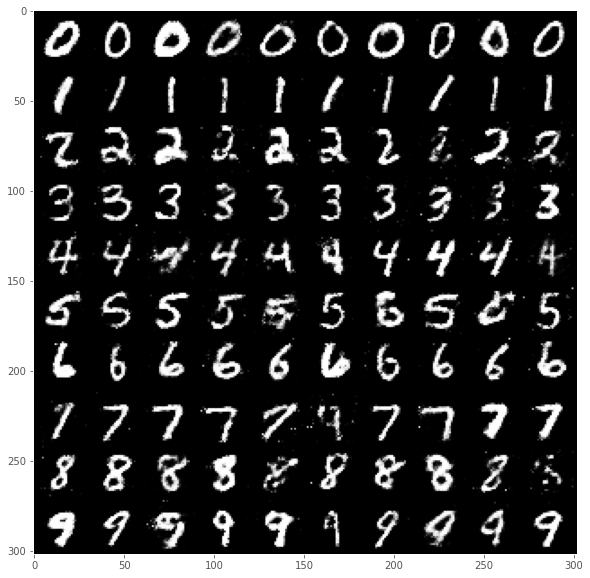

In [21]:
# show output after epochs training
plt.figure(figsize=(10, 10))
plt.grid(False)
plt.imshow(np.asarray(Image.open(os.path.join(sample_dir, "fake_images-0168.png"))))